# Imports

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from setup import neurotransmitters, model_size, device, feat_dim, resize_size, embeddings_path, curated_idx, few_shot_transforms, model
from setup import tqdm, torch, np, os, plt, tqdm
from analysis_utils import display_hdf_image_grid, resize_hdf_image, get_augmented_coordinates
from setup import cosine_similarity, euclidean_distances
from perso_utils import get_fnames, load_image, get_latents
from DINOSim import DinoSim_pipeline
from napari_dinosim.utils import get_img_processing_f

Device: cuda


Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


### Importing model

In [3]:
few_shot = DinoSim_pipeline(model,
                            model.patch_size,
                            device,
                            get_img_processing_f(resize_size),
                            feat_dim, 
                            dino_image_size=resize_size
                            )

files, labels = zip(*get_fnames()) 

### Resize coordinates

In [4]:
resize_factor = resize_size/130
resize = lambda x: resize_factor*x

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Extracting reference data

In [5]:
l = ['A','D','Ga','Glu','O','S']

In [6]:
indices = [
    [1,3,6,8,9],
    [1,2,4,5,6],
    [0,1,2,4,5],
    [1,2,3,6,7],
    [1,2,5,6,8],
    [0,6,10,11,14]
    ]

In [7]:
coords = [
    [(69,63.5),(68,61),(83,57),(76,62),(60,63)],
    [(66,62),(58.5,64),(64,60),(62.5,65),(64,71)],
    [(65,67),(72,60),(63,72),(60,67),(69,66.5)],
    [(65,66),(64,71),(62,58.5),(62,68),(69,55)],
    [(66,60),(60,70),(61,66.6),(58.5,63.5),(62.5,70.5)],
    [(63,73),(58,69),(60,69),(66,64),(62,71)]
    ]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Compute Reference Embeddings

In [8]:
def compute_ref_embeddings(saved_ref_embeddings=False, 
                           embs_path=None, 
                           k=10,
                           data_aug=False):

    if saved_ref_embeddings:
        
        mean_ref = torch.load(embs_path, weights_only=False)
        return mean_ref

    else:

        if data_aug:    
            nb_transformations = len(few_shot_transforms)
            
            # Preload images and metadata once
            good_images = []
            transformed_coordinates = []

            for idx in curated_idx:
                img, coord_x, coord_y = load_image(files[idx])
                good_images.append(img.transpose(1,2,0))
                transformed_coordinates.append([(0, coord_x, coord_y)] * nb_transformations)

            transformed_images = []
            for image in good_images:
                transformed = [t(image).permute(1,2,0) for t in few_shot_transforms]
                transformed_images.extend(transformed)

            for j, img in enumerate(transformed_images):
                if img.shape != torch.Size([130, 130, 1]):
                    h, w = img.shape[:2]
                    h_diff = (130 - h) // 2
                    w_diff = (130 - w) // 2
                    padded_img = torch.zeros(130, 130, 1)
                    padded_img[h_diff:h+h_diff, w_diff:w+w_diff, :] = img
                    transformed_images[j] = padded_img
                    
            batch_size = int(len(curated_idx)/len(neurotransmitters)*nb_transformations) # nb of images in per class
            good_datasets = [transformed_images[i:i+batch_size] for i in range(0,len(transformed_images),batch_size)]
            good_datasets = np.array(good_datasets)
            
            transformed_coordinates = np.vstack(transformed_coordinates)
            good_coordinates = [transformed_coordinates[i:i+batch_size] for i in range(0,len(transformed_coordinates),batch_size)]

        else:
            ref_embs_list = []
            for i, index in tqdm(enumerate(indices)):
                dataset_slice = files[i*600:(i+1)*600]
                imgs = [resize_hdf_image(load_image(dataset_slice[k])[0]) for k in index]
                coordinates = [list(map(resize, c)) for c in coords[i]]
                dataset = list(zip(imgs, coordinates))
                class_wise_embs_list = []
                for image, reference in dataset:
                    few_shot.pre_compute_embeddings(
                        image[None,:,:,:],
                        verbose=False,
                        batch_size=1
                    )
                    few_shot.set_reference_vector(get_augmented_coordinates(reference), filter=None)
                    closest_embds = few_shot.get_k_closest_elements(k=k, return_indices=False) # list of vectors
                    class_wise_embs_list.append(torch.mean(closest_embds.cpu(), dim=0)) # list of lists of vectors
                ref_embs_list.append(class_wise_embs_list) # list of lists of lists of vectors

            ref_embs = np.array([np.mean(class_closest_embs, axis=0) for class_closest_embs in ref_embs_list])
            
            torch.save(ref_embs, os.path.join(embeddings_path, f'{model_size}_mean_ref_{resize_size}_Aug={data_aug}_k={k}'))
            
            return ref_embs

In [9]:
mean_refs = compute_ref_embeddings(True, '/home/tomwelch/Cambridge/Embeddings/giant_mean_ref_518_Aug=False_k=10')
#mean_refs = compute_ref_embeddings(False)

In [10]:
'''
def compute_ref_embeddings(saved_ref_embeddings=False, 
                           embs_path=None, 
                           k=10,
                           data_aug=True):

    if saved_ref_embeddings:
        
        mean_ref = torch.load(embs_path)

    else:

        if data_aug:    
            nb_transformations = len(few_shot_transforms)
            
            # Preload images and metadata once
            good_images = []
            transformed_coordinates = []

            for idx in curated_idx:
                img, coord_x, coord_y = load_image(files[idx])
                good_images.append(img.transpose(1,2,0))
                transformed_coordinates.append([(0, coord_x, coord_y)] * nb_transformations)

            transformed_images = []
            for image in good_images:
                transformed = [t(image).permute(1,2,0) for t in few_shot_transforms]
                transformed_images.extend(transformed)

            for j, img in enumerate(transformed_images):
                if img.shape != torch.Size([130, 130, 1]):
                    h, w = img.shape[:2]
                    h_diff = (130 - h) // 2
                    w_diff = (130 - w) // 2
                    padded_img = torch.zeros(130, 130, 1)
                    padded_img[h_diff:h+h_diff, w_diff:w+w_diff, :] = img
                    transformed_images[j] = padded_img
                    
            batch_size = int(len(curated_idx)/len(neurotransmitters)*nb_transformations) # nb of images in per class
            good_datasets = [transformed_images[i:i+batch_size] for i in range(0,len(transformed_images),batch_size)]
            good_datasets = np.array(good_datasets)
            
            transformed_coordinates = np.vstack(transformed_coordinates)
            good_coordinates = [transformed_coordinates[i:i+batch_size] for i in range(0,len(transformed_coordinates),batch_size)]

        else:

            imgs_coords = [load_image(files[idx]) for idx in curated_idx]
            imgs, xs, ys = zip(*imgs_coords)

            batch_size = int(len(curated_idx)/len(neurotransmitters))
            imgs = [imgs[i:i+batch_size] for i in range(0,len(imgs),batch_size)]
            good_datasets = np.array(imgs).transpose(0,1,3,4,2)
            
            good_coordinates = [(0, x, y) for x, y in zip(xs, ys)]
            good_coordinates = [good_coordinates[i:i+batch_size] for i in range(0,len(good_coordinates),batch_size)]
            good_coordinates = np.array(good_coordinates)


        unfiltered_ref_latents_list, filtered_latent_list, filtered_label_list = [], [], []
        for dataset, batch_label, coordinates in tqdm(zip(good_datasets, neurotransmitters, good_coordinates), desc='Iterating through neurotransmitters'):
            
            # Pre-compute embeddings
            few_shot.pre_compute_embeddings(
                dataset,  # Pass numpy array of images
                overlap=(0.5, 0.5),
                padding=(0, 0),
                crop_shape=(518, 518, 1),
                verbose=True,
                batch_size=10
            )
            
            # Set reference vectors
            few_shot.set_reference_vector(coordinates, filter=None)
            ref = few_shot.get_refs()
            
            # Get closest elements - using the correct method name
            close_embedding =  few_shot.get_k_closest_elements(k=k)
            k_labels =  [batch_label for _ in range(k)]

            
            # Convert to numpy for storing
            close_embedding_np = close_embedding.cpu().numpy() if isinstance(close_embedding, torch.Tensor) else close_embedding
            
            filtered_latent_list.append(close_embedding_np)
            filtered_label_list.append(k_labels)
            
            # Clean up to free memory
            few_shot.delete_precomputed_embeddings()
            few_shot.delete_references()

        mean_ref = torch.from_numpy(np.vstack([np.mean(l, axis=0) for l in filtered_latent_list]))
        # Stack all embeddings and labels
        ref_latents = np.vstack(filtered_latent_list)
        ref_labels = np.hstack(filtered_label_list)
        
        torch.save(mean_ref, os.path.join(dataset_path, f'{model_size}_mean_ref_{resize_size}_Aug={data_aug}_k={k}'))
        torch.save(ref_latents, os.path.join(dataset_path, f'{model_size}_ref_latents_{resize_size}_Aug={data_aug}_k={k}'))
        torch.save(ref_labels, os.path.join(dataset_path, f'{model_size}_ref_labels_{resize_size}_Aug={data_aug}_k={k}'))
'''

"\ndef compute_ref_embeddings(saved_ref_embeddings=False, \n                           embs_path=None, \n                           k=10,\n                           data_aug=True):\n\n    if saved_ref_embeddings:\n        \n        mean_ref = torch.load(embs_path)\n\n    else:\n\n        if data_aug:    \n            nb_transformations = len(few_shot_transforms)\n            \n            # Preload images and metadata once\n            good_images = []\n            transformed_coordinates = []\n\n            for idx in curated_idx:\n                img, coord_x, coord_y = load_image(files[idx])\n                good_images.append(img.transpose(1,2,0))\n                transformed_coordinates.append([(0, coord_x, coord_y)] * nb_transformations)\n\n            transformed_images = []\n            for image in good_images:\n                transformed = [t(image).permute(1,2,0) for t in few_shot_transforms]\n                transformed_images.extend(transformed)\n\n            for j, img

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Generate Ground-truth

In [11]:
one_hot_neurotransmitters = np.zeros((len(neurotransmitters),len(neurotransmitters))) + np.identity(len(neurotransmitters))
emb_labels = np.hstack([[neuro]*feat_dim*600 for neuro in neurotransmitters]).reshape(-1,1)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Compute Datasetwide Embeddings

In [12]:
import gc

#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [13]:
def embedding_generator():

        files, _ = zip(*get_fnames()) 
        images = np.array([resize_hdf_image(load_image(file)[0]) for file in tqdm(files, desc='Loading images')])

        for i in range(0,3600, 50):
                batch = images[i:i+50]
                few_shot.pre_compute_embeddings(
                        batch,
                        batch_size=1, 
                        verbose=False
                        )
                torch.cuda.empty_cache()
                gc.collect()
                del batch
                yield few_shot.get_embeddings(reshape=True).cpu()
                
def compute_embeddings():
        g = compute_embeddings()        

        embeddings_list = []

        length = 3600//50
        for _ in tqdm(range(length)): embeddings_list.extend(next(g))
        return embeddings_list

In [14]:
new_embeddings = torch.load('/home/tomwelch/Cambridge/Embeddings/giant_dataset_embs_518.pt')

AttributeError: 'list' object has no attribute 'shape'

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Compute class-wise accuracies

In [33]:
from analysis_utils import get_threshold

def compute_accuracies(reference_embeddings = mean_refs, 
                       embeddings = new_embeddings,
                       metric = euclidean_distances,
                       distance_threshold = 0.01
                       ):

    batch_size = int(len(embeddings)/6)

    for n, i in tqdm(enumerate(range(0, len(embeddings), batch_size))):
        batch = embeddings[i:i+batch_size]

        #embeddings = embeddings.reshape(-1, feat_dim)
        similarity_matrix = metric(reference_embeddings, batch)
        similarity_matrix_normalized = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))
        threshold = get_threshold(similarity_matrix_normalized, 0.9)
        similarity_matrix_normalized_filtered = np.where(similarity_matrix_normalized <= threshold, similarity_matrix_normalized, 0)

        batch_score_list = []
        for k in range(batch_size):

            column = similarity_matrix_normalized_filtered[:,k]
            j=0
            if sum(column) == 0:
                j+=1
            else:
                patch_wise_distances_filtered = np.where(column == 0, 1, column)
                output_class = one_hot_neurotransmitters[np.argmin(patch_wise_distances_filtered)]
                gt_index = n
                ground_truth = one_hot_neurotransmitters[gt_index]
                score = np.sum(output_class*ground_truth)
                batch_score_list.append(score)
                
        yield batch_score_list

g = compute_accuracies()
score_list = []

for _ in range(6): score_list.append(next(g))

accuracies = [np.mean(scores)*100 for scores in score_list]
#print(f'{j} embeddings did not pass the threshold')
#return accuracies

5it [03:23, 40.74s/it]
0it [00:00, ?it/s]

5it [01:25, 16.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Plot results

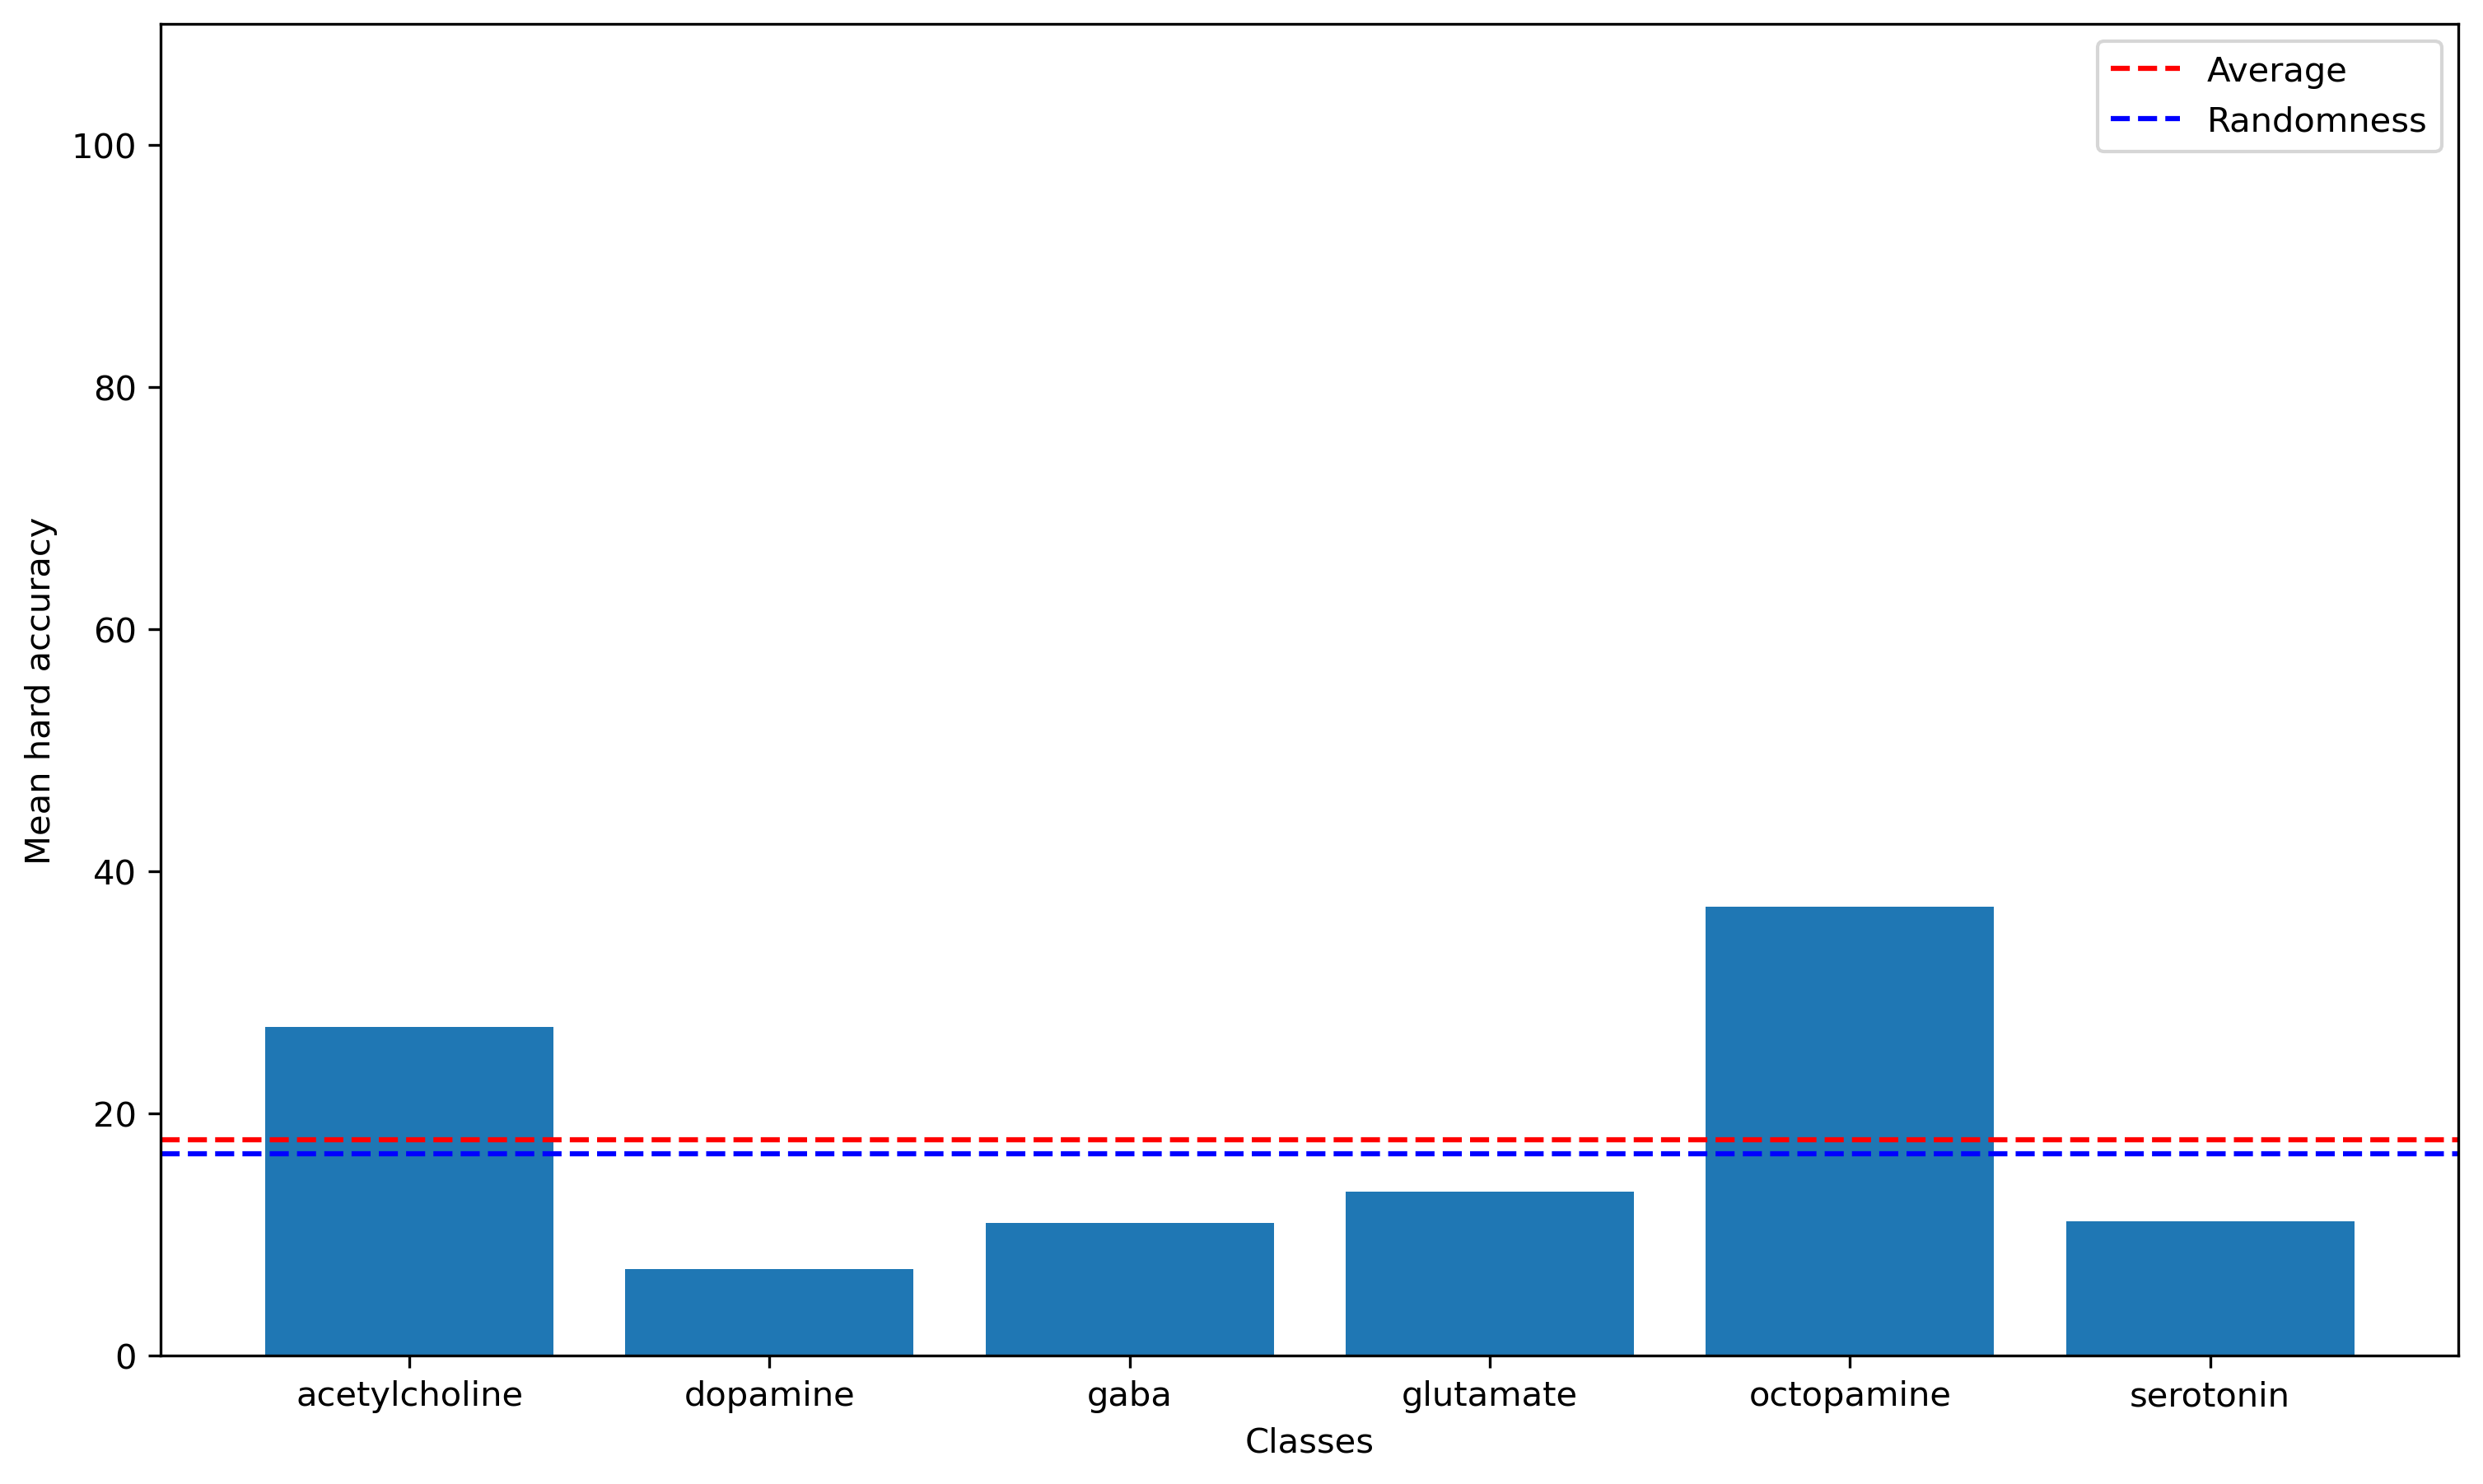

In [34]:
plt.figure(figsize=(12,7), dpi=300)
plt.bar(neurotransmitters, accuracies)
plt.xlabel('Classes')
plt.ylabel('Mean hard accuracy')
#plt.title(f'Mean hard accuracies across classes - {model_size} DINOv2 - 140x140 images - Threshold = {distance_threshold} - Data augmentation: {data_aug}')
plt.axhline(np.mean(accuracies), color='r', linestyle='--', label='Average')
plt.axhline(y=(100/6), color='b', linestyle='--', label='Randomness')
plt.legend()
ax = plt.gca()
ax.set_ylim([0,110])
plt.show()